In [11]:
import os
import torch
from torch.utils.data import Dataset, random_split
from datasets import load_dataset, DatasetDict, Dataset as HFDataset
from tqdm import tqdm

import numpy as np

In [2]:
cache_dir = 'data/cache'
train_cache_path = os.path.join(cache_dir, 'affectnet_train.pt')
test_cache_path = os.path.join(cache_dir, 'affectnet_test.pt')

In [31]:
dataset = load_dataset('chitradrishti/AffectNet', cache_dir=cache_dir)['train']

In [4]:
dataset.features,dataset

({'image': Image(mode=None, decode=True, id=None),
  'label': ClassLabel(names=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)},
 Dataset({
     features: ['image', 'label'],
     num_rows: 31002
 }))

In [5]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1547x1547>,
 'label': 0}

In [6]:
import PIL
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
dataset.take(10).map(lambda x: {'image': np.array(x['image']), 'label': x['label']})

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/root/miniconda3/envs/rapids-21.12/lib/python3.12/site-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Dataset({
    features: ['image', 'label'],
    num_rows: 10
})

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1547x1547 at 0x7FD9639ED4F0>
[[[89 63 48]
  [91 65 50]
  [94 66 52]
  ...
  [35 41 53]
  [31 37 49]
  [29 33 44]]

 [[93 67 52]
  [95 69 54]
  [99 71 57]
  ...
  [36 42 54]
  [32 38 50]
  [30 34 45]]

 [[92 69 55]
  [94 71 57]
  [99 73 60]
  ...
  [37 43 55]
  [33 39 51]
  [29 36 46]]

 ...

 [[14 17 24]
  [15 18 25]
  [16 19 26]
  ...
  [20 24 33]
  [19 23 32]
  [19 23 32]]

 [[14 17 24]
  [15 18 25]
  [16 19 26]
  ...
  [20 24 33]
  [20 24 33]
  [20 24 33]]

 [[14 17 24]
  [14 17 24]
  [15 18 25]
  ...
  [20 24 33]
  [20 24 33]
  [20 24 33]]]


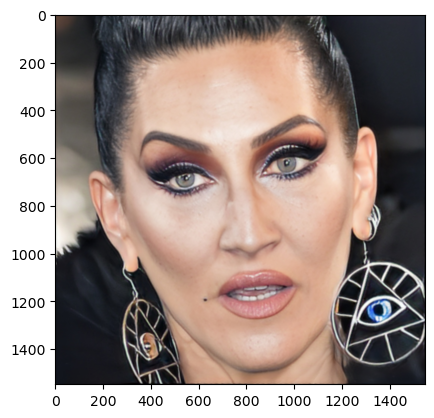

In [14]:


image = dataset[0]['image']
print(image)
imagearray = np.array(image)
print(imagearray)
plt.imshow(imagearray)

In [17]:
random_mapping = np.random.permutation(len(dataset))

In [30]:
from datasets import Dataset,IterableDataset

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
from torchvision import transforms as tf
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

# Ensure that the script is protected to avoid issues with multiprocessing on some platforms
if __name__ == "__main__":
    class AffectNetDataset(IterableDataset):
        def __init__(self, cache_dir='data/cache', transform=None):
            """
            Initializes the AffectNetDataset.

            Args:
                cache_dir (str): Directory to cache the dataset.
                transform (callable, optional): Optional transform to be applied
                    on a sample.
            """
            super().__init__()
            self.dataset = load_dataset('chitradrishti/AffectNet', cache_dir=cache_dir)['train']
            self.total_size = len(self.dataset)
            self.random_mapping = np.random.permutation(self.total_size)
            self.transform = transform if transform else tf.Compose([
                tf.Resize((64, 64)),  # Resize first to ensure compatibility with ToTensor
                tf.ToTensor()
            ])

        def __iter__(self):
            """
            Creates an iterator for the dataset, ensuring that each worker
            processes a unique subset of data.
            """
            worker_info = get_worker_info()
            if worker_info is None:
                # Single-worker case
                indices = self.random_mapping
                num_workers = 1
                worker_id = 0
            else:
                # Multi-worker case: split the data among workers
                num_workers = worker_info.num_workers
                worker_id = worker_info.id
                per_worker = int(np.ceil(self.total_size / float(num_workers)))
                start = worker_id * per_worker
                end = min(start + per_worker, self.total_size)
                indices = self.random_mapping[start:end]

            for idx in indices:
                sample = self.dataset[int(idx)]
                label = sample['label']
                if label != 5:
                    image = sample['image']
                    if isinstance(image, Image.Image):
                        # Apply transformations
                        image = self.transform(image)
                    else:
                        # If image is not a PIL Image, convert it
                        image = self.transform(Image.fromarray(image))
                    yield {'image': image, 'label': label}

    # Define transformations (if any additional transformations are needed)
    transform = tf.Compose([
        tf.Grayscale(num_output_channels=1),
        tf.Resize((64, 64)),
        tf.ToTensor(),
        # Add more transformations if required
    ])

    # Initialize the dataset
    affectnet_dataset = AffectNetDataset(transform=transform)

    # Define DataLoader parameters
    batch_size = 32
    num_workers = 4  # Adjust based on your CPU cores
    prefetch_factor = 10  # Number of batches to prefetch per worker

    # Initialize DataLoader
    afdataloader = DataLoader(
        affectnet_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        prefetch_factor=prefetch_factor,
        pin_memory=True,  # Set to True if using GPU
        drop_last=False,  # Set to True to drop the last incomplete batch
    )
    
    
    # Function to iterate and print batch details
    def iterate_batches(dataloader, num_batches=10):
        """
        Iterates over the DataLoader and prints the shape of images and labels.

        Args:
            dataloader (DataLoader): The DataLoader to iterate over.
            num_batches (int): Number of batches to iterate.
        """
        i = 0
        for batch in tqdm(dataloader, desc="Loading Batches"):
            i += 1
            images, labels = batch['image'], batch['label']
            print(f"Batch {i}:")
            print(f"  Images Shape: {images.shape}")  # Expected: [batch_size, C, H, W]
            print(f"  Labels Shape: {labels.shape}")  # Expected: [batch_size]
            if i >= num_batches:
                break

    # Iterate over a few batches to test
    iterate_batches(afdataloader, num_batches=10)


Loading Batches: 1it [00:11, 11.52s/it]

Batch 1:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 2it [00:11,  5.00s/it]

Batch 2:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 3it [00:12,  2.89s/it]

Batch 3:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 4it [00:13,  2.04s/it]

Batch 4:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 5it [00:22,  4.62s/it]

Batch 5:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 6it [00:22,  3.14s/it]

Batch 6:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 7it [00:24,  2.78s/it]

Batch 7:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])
Batch 8:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 9it [00:33,  3.62s/it]

Batch 9:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])
Batch 10:
  Images Shape: torch.Size([32, 1, 64, 64])
  Labels Shape: torch.Size([32])


Loading Batches: 9it [00:43,  4.85s/it]


In [14]:
import os
import numpy as np
import threading
import queue
import signal
import sys
from datasets import load_dataset
from torch.utils.data import IterableDataset
from torchvision import transforms as tf
from PIL import Image
import torch

# ------------------- AffectNetDataset -------------------
class AffectNetDataset(IterableDataset):
    def __init__(self, cache_dir='data/cache', transform=None):
        """
        Initializes the AffectNetDataset.

        Args:
            cache_dir (str): Directory to cache the dataset.
            transform (callable, optional): Transformations to apply to the images.
        """
        # Load the dataset from HuggingFace Datasets
        self.dataset = load_dataset('chitradrishti/AffectNet', cache_dir=cache_dir)['train']
        self.total_size = len(self.dataset)
        
        # Define transformations; default is resizing to 64x64 and converting to tensor
        self.transform = transform if transform else tf.Compose([
            tf.Resize((64, 64)),
            tf.ToTensor()
        ],device='cuda')
        
        # Shuffle the dataset indices for randomness
        self.random_mapping = np.random.permutation(self.total_size)

    def __iter__(self):
        """
        Creates an iterator over the dataset.

        Yields:
            dict: A dictionary containing the transformed image tensor and its label.
        """
        for idx in self.random_mapping:
            sample = self.dataset[int(idx)]
            label = sample['label']
            
            # Filter out samples with label == 5
            if label != 5:
                image = sample['image']
                
                # Ensure image is a PIL Image; convert if necessary
                if not isinstance(image, Image.Image):
                    image = Image.fromarray(image)
                
                # Apply transformations
                image = self.transform(image)
                
                yield {'image': image, 'label': label}

# ------------------- BufferedDataLoader -------------------
class BufferedDataLoader:
    def __init__(self, dataset, buffer_size=500, prefetch_size=50, batch_size=32):
        """
        Initializes the BufferedDataLoader with batching.

        Args:
            dataset (IterableDataset): The dataset to load data from.
            buffer_size (int): Maximum number of samples to keep in the buffer.
            prefetch_size (int): Number of samples to load when the buffer is low.
            batch_size (int): Number of samples per batch.
        """
        self.dataset = dataset
        self.buffer_size = buffer_size
        self.prefetch_size = prefetch_size
        self.batch_size = batch_size
        self.queue = queue.Queue(maxsize=self.buffer_size)
        self.stop_event = threading.Event()
        self.thread = threading.Thread(target=self._producer)
        self.thread.daemon = True  # Daemonize thread to exit when main thread exits
        self.thread.start()

    def _producer(self):
        """
        The producer thread that loads data into the buffer.
        """
        try:
            for sample in self.dataset:
                if self.stop_event.is_set():
                    break
                self.queue.put(sample)  # Blocks if queue is full
        except Exception as e:
            print(f"Producer encountered an error: {e}")
        finally:
            # Signal that no more data will be added
            self.queue.put(None)

    def __iter__(self):
        """
        Creates an iterator that yields data from the buffer.

        Yields:
            dict: A dictionary containing batched image tensors and labels.
        """
        return self

    def __next__(self):
        """
        Retrieves the next batch from the buffer.

        Returns:
            dict: A dictionary containing batched image tensors and labels.

        Raises:
            StopIteration: If no more data is available.
        """
        batch_images = []
        batch_labels = []
        for _ in range(self.batch_size):
            sample = self.queue.get()
            if sample is None:
                self.stop_event.set()
                if batch_images:
                    break  # Yield the last batch which may be smaller
                else:
                    raise StopIteration
            batch_images.append(sample['image'])
            batch_labels.append(sample['label'])
        
        if not batch_images:
            raise StopIteration
        
        # Stack images into a single tensor
        batch = {
            'image': torch.stack(batch_images),
            'label': torch.tensor(batch_labels)
        }
        return batch

    def shutdown(self):
        """
        Shuts down the producer thread and clears the buffer.
        """
        self.stop_event.set()
        self.thread.join()
        # Clear the queue
        while not self.queue.empty():
            self.queue.get()

    def __len__(self):
        """
        Returns the approximate number of samples in the buffer.

        Returns:
            int: Number of samples currently in the buffer.
        """
        return self.queue.qsize()

# ------------------- Main Function -------------------
def main():
    # Define transformations (customize as needed)
    transform = tf.Compose([
        tf.Resize((64, 64)),
        tf.RandomHorizontalFlip(),
        tf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        tf.ToTensor(),
        tf.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    # Initialize the dataset
    affectnet_dataset = AffectNetDataset(transform=transform)

    # Initialize the buffered data loader
    buffered_loader = BufferedDataLoader(
        affectnet_dataset,
        buffer_size=500,     # Maximum number of samples in buffer
        prefetch_size=50,    # Number of samples to load when buffer is low
        batch_size=32        # Number of samples per batch
    )

    # Define a signal handler to gracefully shutdown on interruption (e.g., Ctrl+C)
    def signal_handler(sig, frame):
        print("\nShutting down gracefully...")
        buffered_loader.shutdown()
        sys.exit(0)

    # Register the signal handler for SIGINT (Ctrl+C)
    signal.signal(signal.SIGINT, signal_handler)

    # Iterate over the buffered data loader
    try:
        for i, batch in enumerate(buffered_loader):
            images, labels = batch['image'], batch['label']
            print(f"Batch {i+1}: Images Shape: {images.shape}, Labels Shape: {labels.shape}")
            
            # Insert your training or evaluation code here
            # Example:
            # outputs = model(images)
            # loss = criterion(outputs, labels)
            # loss.backward()
            # optimizer.step()

            if i == 9:  # Example: Stop after 10 batches
                print("Reached 10 batches, stopping.")
                break
    except Exception as e:
        print(f"Error during data loading: {e}")
    finally:
        buffered_loader.shutdown()

# ------------------- Execute Main -------------------
if __name__ == "__main__":
    main()


Batch 1: Images Shape: torch.Size([32, 3, 64, 64]), Labels Shape: torch.Size([32])
Batch 2: Images Shape: torch.Size([32, 3, 64, 64]), Labels Shape: torch.Size([32])

Shutting down gracefully...


SystemExit: 0

/root/miniconda3/envs/rapids-21.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [68]:
afdataloader.dataset.loaded_num

0